Давайте подивимося, як LSTM можна використовувати для побудови нейронної мережі прогнозування часових.

Будемо працювати з задачею прогнозування кількості пасажирів міжнародних авіаліній. З цим набором даних ми вже працювали в лекції "Time Series Analysis" і ви зможете порівняти результати :)

Задача полягає в тому, щоб за заданими роком і місяцем передбачити кількість пасажирів міжнародних авіаліній в одиницях виміру 1,000. Дані охоплюють період з січня 1949 року по грудень 1960 року, тобто 12 років, зі 144 спостереженнями.

Це регресійна задача. Тобто, знаючи кількість пасажирів (в тисячах) за останні місяці, можна передбачити, якою буде кількість пасажирів у наступному місяці. Набір даних має лише одну характеристику: "Кількість пасажирів" - `Passengers`.

Далі вже наведений код для читання даних, але нам їх ще треба буде трошки обробити.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Завантаження даних
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url)
df.set_index('Month', inplace=True)
display(df.head())

,Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


**Завдання 1.** Створіть змінну типу `numpy.ndarray`, яка містить значення кількості пасажирів в форматі `float32`. Такий формат даних нам треба для тренування нейромережі.

In [6]:
# Вилучення кількості пасажирів із колонки 'Passengers'
passenger_data = df['Passengers'].values
passenger_data[:5]

array([112, 118, 132, 129, 121])

Очікуваний результат:
```array([112., 118., 132., 129., 121.], dtype=float32)```

**Завдання 2**. Розбийте дані на тренувальні і валідаційні у співвідношенні 67% йде у тренування, 33 - у валідацію. Памʼятаємо, що ми працюємо з tim series, відповідно, навчаємось на давніших, валідуємось - на новіших.

In [7]:
# Розбивка даних на тренувальні та валідаційні у співвідношенні 67:33
train_size = int(len(passenger_data) * 0.67)
train_data, validation_data = passenger_data[:train_size], passenger_data[train_size:]

# Перевірка кількості даних у тренувальній та валідаційній вибірках
len(train_data), len(validation_data)

(96, 48)

**Завдання 3**.

Реалізуйте функцію `create_dataset`, яка перетворить одномірний часовий ряд (набір даних) у формат, придатний для тренування нейромережі.

Функція повинна приймати два аргументи:
- `dataset` — numpy-масив часового ряду,
- `lookback` — кількість попередніх кроків, які використовуватимуться для передбачення.

Функція повинна повернути два **тензори** PyTorch:
- `X` — набір ознак (вікно попередніх значень),
- `y` — цільові значення (наступні після вікна кроки).

Дані ми будемо подавати моделі в наступному форматі:
`
tensor([[112.],
        [118.],
        [132.],
        [129.],
        [121.]])
`
Відповідно першою розмірністю буде йти розмір вхідного батча, а другою - розмір вхіднизх даних і в нас це 1, бо лише одне значення на вході щоразу.

Після виконання завдання запустіть код нижче. Ми будемо передбачати на основі кількості пасажирів в попередній день кількість пасажирів в наступний, тому `lookback == 1`.

In [11]:
import torch

# функція create_dataset
def create_dataset(dataset, lookback=1):
    X, y = [], []
    for i in range(len(dataset) - lookback):
        X.append(dataset[i:i + lookback])  # Вікно попередніх значень
        y.append(dataset[i + lookback])    # Наступне значення після вікна
    # Конвертуємо в тензори PyTorch
    X = torch.tensor(X).float()
    y = torch.tensor(y).float().unsqueeze(-1)
    return X, y

# Виклик функції для тестування із lookback == 1
lookback = 1
X, y = create_dataset(train_data, lookback)

# Перегляд першого прикладу з тренувального датасету
print(X[0], y[0])

tensor([112.]) tensor([118.])


In [12]:
lookback = 1

# Використання правильних змінних
X_train, y_train = create_dataset(train_data, lookback=lookback)
X_test, y_test = create_dataset(validation_data, lookback=lookback)

# Перевірка форм тензорів для тренувальних та валідаційних вибірок
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([95, 1]) torch.Size([95, 1])
torch.Size([47, 1]) torch.Size([47, 1])


Очікуваний результат:
```
torch.Size([95, 1]) torch.Size([95, 1])
torch.Size([47, 1]) torch.Size([47, 1])
```

**Завдання 4**.

Зверніть увагу на розмірності в попередньому завданні. Ми
З допомогою модуля `torch.nn` опишіть клас `AirModel`, який є нейронною мережею для прогнозування кількості пасажирів за допомогою LSTM.

1. **Конструктор класу** повинен приймати параметри `hidden_size`, `num_layers` та ініціювати шари:
   - LSTM-шар з наступними параметрами:
     - `input_size` — кожна точка часового ряду є окремим входом,,
     - `hidden_size` — заданий в конструкторі класу мережі,
     - `num_layers=1` — кількість шарів LSTM, задана в конструкторі мережі,
     - `batch_first=True` — визначає, що першим виміром є розмір батчу.
   - Лінійний шар (`nn.Linear`) для перетворення виходу LSTM на прогноз однієї точки.

2. **Метод forward** повинен виконувати наступні дії:
   - Передати вхідний тензор через LSTM-шар і отримати виходи (ігноруючи приховані стани).
   - Пропустити вихід LSTM через лінійний шар для отримання остаточного прогнозу.

Створіть об'єкт класу `AirModel` зі значеннями параметрів `hidden_size=50`, `num_layers=1` і протестуйте роботу моделі на вхідному тензорі `tensor([[112.]])`. На цьому етапі ми маємо переконатись, що модель здатна генерувати передбачення з рандомно ініційованими вагами.

In [13]:
import torch
import torch.nn as nn

# Опис класу нейронної мережі для прогнозування кількості пасажирів
class AirModel(nn.Module):
    def __init__(self, hidden_size, num_layers):
        super(AirModel, self).__init__()
        # LSTM шар
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        # Лінійний шар для перетворення виходу LSTM на прогноз
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # Передаємо через LSTM-шар і отримуємо вихід
        lstm_out, _ = self.lstm(x)
        # Пропускаємо вихід через лінійний шар
        prediction = self.linear(lstm_out[:, -1, :])  # Використовуємо останній часовий крок
        return prediction

# Створення об'єкта AirModel зі значеннями hidden_size=50 та num_layers=1
model = AirModel(hidden_size=50, num_layers=1)

# Тест моделі на вхідному тензорі
test_input = torch.tensor([[112.]]).float().unsqueeze(0)  # Додано розмірність для батчу
test_output = model(test_input)

print(test_output)


tensor([[-0.0521]], grad_fn=<AddmmBackward0>)


**Завдання 5**.

Створіть об'єкт DataLoader для завантаження даних, використовуючи тренувальні вибірки `X_train` та `y_train`. Ваш DataLoader повинен виконувати наступні вимоги:

1. Використовувати клас `TensorDataset`, щоб об'єднати тензори ознак `X_train` і цільових значень `y_train`.
2. Дані повинні завантажуватися невеликими батчами розміром 8 за допомогою параметра `batch_size`.
3. Використовувати параметр `shuffle=True`, щоб дані перемішувалися перед кожною епохою тренування.


In [14]:
from torch.utils.data import DataLoader, TensorDataset

# Створення об'єкта TensorDataset для тренувальних даних
train_dataset = TensorDataset(X_train, y_train)

# Створення DataLoader для завантаження даних з параметрами batch_size=8 та shuffle=True
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Перевірка кількості батчів у DataLoader
num_batches = len(train_loader)
print(f'Number of batches: {num_batches}')

Number of batches: 12


**Завдання 6**.

1. Реалізуйте навчання нейронної мережі `AirModel` для прогнозування часових рядів, використовуючи Adam-оптимізатор та функцію втрат MSE (середньоквадратичну похибку).
2. Створіть цикл тренування для 2000 епох, у якому на кожній епосі:
   - Виконуйте крок тренування моделі (прямий прохід, обчислення похибки, зворотний прохід і оновлення ваг).
   - Підраховуйте середню похибку на кожному батчі даних і зберігайте її у списку `losses`.
3. Раз на 100 епох проводьте валідацію моделі:
   - Перевіряйте модель на тренувальних та тестових даних без оновлення ваг.
   - Обчислюйте корінь середньоквадратичної похибки (RMSE) для тренувальної та тестової вибірок і виводьте результати на екран.
   
**Примітка:**
- Використовуйте вже створений `DataLoader` для отримання батчів даних.
- Валідацію виконуйте в режимі `eval()`, вимикаючи обчислення градієнтів з `torch.no_grad()`.

**Приклад виходу:**
```
Epoch 0: train RMSE 12.3456, test RMSE 15.6789
Epoch 100: train RMSE 9.8765, test RMSE 12.3456
...
```

In [16]:
# Цикл тренування
for epoch in range(num_epochs):
    model.train()  # Увімкнути режим тренування
    epoch_loss = 0  # Втрата для поточної епохи

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()  # Очищення градієнтів

        # Розширити розмірність X_batch для LSTM (batch_size, sequence_length, input_size)
        X_batch = X_batch.view(X_batch.size(0), 1, 1)  # reshape to (batch_size, 1, 1)

        output = model(X_batch)  # Прямий прохід
        loss = criterion(output, y_batch)  # Обчислення втрат
        loss.backward()  # Зворотний прохід
        optimizer.step()  # Оновлення ваг

        epoch_loss += loss.item()  # Додавання втрат на батч

    # Середня втрата за епоху
    avg_loss = epoch_loss / len(train_loader)
    losses.append(avg_loss)

    # Валідація кожні 100 епох
    if (epoch + 1) % 100 == 0:
        model.eval()  # Увімкнути режим валідації
        with torch.no_grad():  # Вимкнення обчислення градієнтів
            # Валідація на тренувальних даних
            train_outputs = model(X_train.view(X_train.size(0), 1, 1))  # reshape for model
            train_rmse = torch.sqrt(criterion(train_outputs, y_train)).item()

            # Валідація на тестових даних
            test_outputs = model(X_test.view(X_test.size(0), 1, 1))  # reshape for model
            test_rmse = torch.sqrt(criterion(test_outputs, y_test)).item()

        print(f'Epoch {epoch}: train RMSE {train_rmse:.4f}, test RMSE {test_rmse:.4f}')


Epoch 99: train RMSE 184.1099, test RMSE 378.5445
Epoch 199: train RMSE 151.0283, test RMSE 342.8073
Epoch 299: train RMSE 122.5044, test RMSE 310.2643
Epoch 399: train RMSE 99.2881, test RMSE 280.8514
Epoch 499: train RMSE 81.0536, test RMSE 254.4989
Epoch 599: train RMSE 64.8071, test RMSE 229.1592
Epoch 699: train RMSE 52.2762, test RMSE 206.0538
Epoch 799: train RMSE 43.1010, test RMSE 185.5293
Epoch 899: train RMSE 36.5498, test RMSE 167.2460
Epoch 999: train RMSE 31.4627, test RMSE 151.8660
Epoch 1099: train RMSE 29.9376, test RMSE 139.6477
Epoch 1199: train RMSE 26.7490, test RMSE 129.4641
Epoch 1299: train RMSE 26.7369, test RMSE 122.0708
Epoch 1399: train RMSE 24.6366, test RMSE 115.0791
Epoch 1499: train RMSE 24.1748, test RMSE 110.4197
Epoch 1599: train RMSE 23.9596, test RMSE 106.0352
Epoch 1699: train RMSE 23.7643, test RMSE 104.1191
Epoch 1799: train RMSE 23.8283, test RMSE 100.4953
Epoch 1899: train RMSE 23.3771, test RMSE 99.1614
Epoch 1999: train RMSE 24.8439, test RMS

**Завдання 7.** Побудуйте графік лосів. Зробіть висновок з графіку, чи навчилась модель?

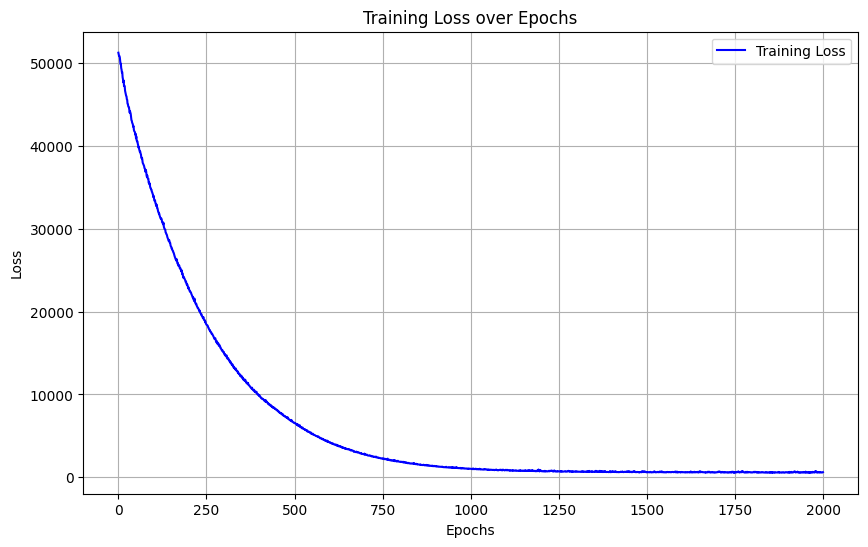

In [17]:
import matplotlib.pyplot as plt

# Побудова графіку лосів
plt.figure(figsize=(10, 6))
plt.plot(losses, label='Training Loss', color='blue')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Модель навчилась, але не факт, що точно)

Доволі неочікувано, що середньоквадратичне відхилення тестового набору даних буде на порядок більшим за одиниці в нашому наборі даних. Середньоквадратичне відхилення 100 означає, що прогноз і фактичне значення будуть відрізнятися в середньому на 100 (тобто, 100 000 пасажирів у цьому наборі даних).



Щоб краще зрозуміти якість прогнозу, ви можете побудувати графік з кодом нижче (а ще нижче - описано, що відбувається в цьому коді, бо це теж корисно зрозуміти):

In [40]:
# Перетворення X_train та X_test у тривимірний формат
X_train = X_train.unsqueeze(1)  # Додаємо ще одну вимірність, отримуючи форму [95, 1, 1]
X_test = X_test.unsqueeze(1)    # Отримуємо форму [47, 1, 1]

print("New shape of X_train:", X_train.shape)
print("New shape of X_test:", X_test.shape)


New shape of X_train: torch.Size([95, 1, 1])
New shape of X_test: torch.Size([47, 1, 1])


In [41]:
class AirModel(nn.Module):
    def __init__(self, hidden_size, num_layers):
        super(AirModel, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # Збільшуємо розмірність x, щоб він став 3D: (batch_size, sequence_length, input_size)
        x = x.unsqueeze(1)  # Додаємо розмірність для input_size

        # Прямий прохід через LSTM
        lstm_out, _ = self.lstm(x)

        # Перевірка форми lstm_out
        print("Shape of lstm_out:", lstm_out.shape)  # Для дебагу

        # Використовуємо останній часовий крок
        if lstm_out.dim() == 3:  # якщо тривимірний
            prediction = self.linear(lstm_out[:, -1, :])  # використовуємо останній часовий крок
        else:  # якщо двовимірний
            prediction = self.linear(lstm_out)  # використовуємо вихід LSTM напряму

        return prediction

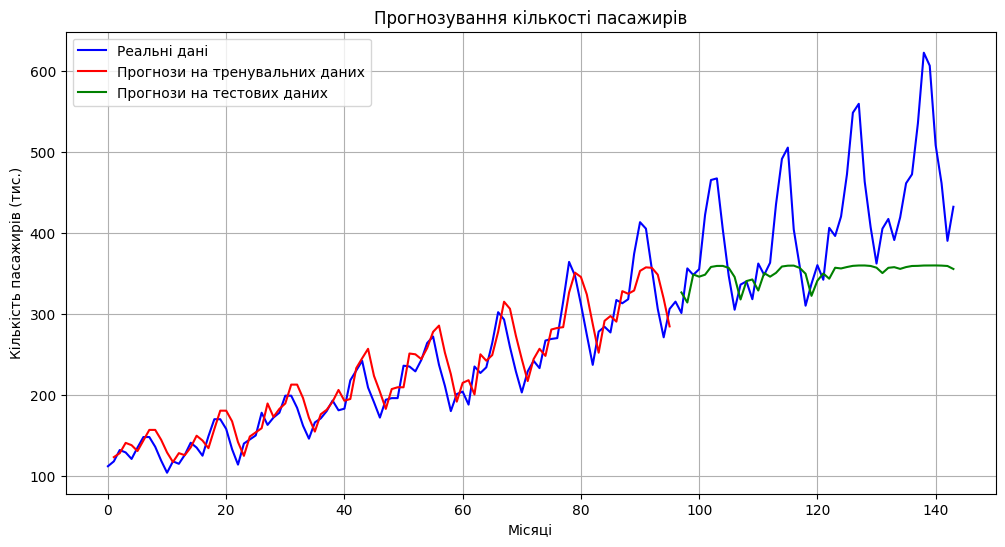

In [42]:
def plot_predicts():
    with torch.no_grad():
        # Зсув прогнозів для тренувальних даних
        train_plot = np.ones_like(timeseries) * np.nan
        y_pred_train = model(X_train).numpy()  # Отримуємо прогнози для тренувальних даних
        train_plot[lookback:train_size] = y_pred_train.flatten()  # flatten для збереження правильного розміру

        # Зсув прогнозів для тестових даних
        test_plot = np.ones_like(timeseries) * np.nan
        y_pred_test = model(X_test).numpy()  # Отримуємо прогнози для тестових даних
        test_plot[train_size + lookback:len(timeseries)] = y_pred_test.flatten()  # flatten

    # Візуалізація результатів
    plt.figure(figsize=(12, 6))
    plt.plot(timeseries, c='b', label='Реальні дані')  # Реальні дані
    plt.plot(train_plot, c='r', label='Прогнози на тренувальних даних')  # Прогнози на тренувальних даних
    plt.plot(test_plot, c='g', label='Прогнози на тестових даних')  # Прогнози на тестових даних
    plt.legend()
    plt.title('Прогнозування кількості пасажирів')
    plt.xlabel('Місяці')
    plt.ylabel('Кількість пасажирів (тис.)')
    plt.grid()
    plt.show()

# Виклик функції
plot_predicts()

**Що відбувається в коді вище.** В цьому коді здійснюється процес прогнозування часових рядів за допомогою LSTM моделі, а також виведення графіку, який показує реальні значення, тренувальні та тестові прогнози. Ось що відбувається на кожному етапі:

1. **`torch.no_grad()`**: Цей контекстний менеджер вимикає обчислення градієнтів, що означає, що під час прогнозування не будуть зберігатися проміжні обчислення для зворотного проходу (backpropagation). Це підвищує ефективність під час прогнозування і зменшує використання пам'яті.

2. **Зсув прогнозів для тренувальних даних:**
   - Створюється масив `train_plot`, який має такий самий розмір, як і часовий ряд (`timeseries`), і заповнюється значеннями NaN (`np.nan`), щоб залишити місце для реальних значень.
   - Модель передбачає виходи для тренувальних даних `X_train`.
   - Використовується лише останнє передбачене значення для кожного входу LSTM (`y_pred[:, -1]`).
   - Прогнози зсуваються, починаючи з індексу `lookback` до кінця тренувальних даних (індекс `train_size`). Цей зсув потрібен, щоб зробити прогноз на основі попередніх даних і відобразити його на правильній частині графіку.

3. **Зсув прогнозів для тестових даних:**
   - Створюється масив `test_plot`, який також заповнюється NaN.
   - Прогнози для тестових даних додаються з індексу `train_size + lookback` до кінця реальних даних, щоб відобразити, де модель починає прогнозувати тестову вибірку.

4. **Побудова графіка:**
   - `plt.plot(timeseries, c='b')`: Виводить реальні значення часового ряду (синя лінія).
   - `plt.plot(train_plot, c='r')`: Виводить тренувальні прогнози (червона лінія).
   - `plt.plot(test_plot, c='g')`: Виводить тестові прогнози (зелена лінія).

**Чому це робиться:**
- Зсув прогнозів для тренувальних і тестових даних дозволяє візуально зрівняти, наскільки добре модель прогнозує як на тренувальній, так і на тестовій вибірках. Зазвичай, червона лінія (тренувальні прогнози) повинна точно відповідати синій лінії (реальні дані), а зелена лінія (тестові прогнози) дає змогу побачити, наскільки модель добре працює на нових даних, яких вона раніше не бачила.

**Завдання 8**. Навчіть модель з hidden_size=100 та порівняйте результати прогнозів з попередніми.

In [51]:
from torch.utils.data import DataLoader, TensorDataset

# Припустимо, ваші дані мають форму (num_samples, 1)
# Створіть TensorDataset і DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Аналогічно для тестових даних
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [54]:
def forward(self, x):
    # Reshape x to be 3D: (batch_size, sequence_length, input_size)
    x = x.unsqueeze(1)  # Додаємо новий вимір

    lstm_out, _ = self.lstm(x)
    print("Shape of lstm_out:", lstm_out.shape)

    # Отримуємо вихід для останнього часового кроку
    last_time_step = lstm_out[:, -1, :]  # Зараз це має бути (batch_size, hidden_size)

    prediction = self.linear(last_time_step)  # Пропускаємо через лінійний шар
    return prediction

In [60]:
# Цикл навчання
for epoch in range(num_epochs):
    model_100.train()  # Переходимо в режим навчання
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()  # Очищення градієнтів

        # Видаляємо зайві виміри з X_batch, залишаючи лише 3
        X_batch = X_batch.squeeze()  # Видаляємо всі виміри розміром 1
        X_batch = X_batch.unsqueeze(1)  # Додаємо вимір для input_size, якщо потрібно

        # Перевірка форми
        print(f"Epoch {epoch}, X_batch shape: {X_batch.shape}, y_batch shape: {y_batch.shape}")

        output = model_100(X_batch)  # Вихід моделі
        loss = criterion(output, y_batch.unsqueeze(1))  # Обчислення втрат
        loss.backward()  # Зворотний прохід
        optimizer.step()  # Оновлення ваг

    # Валідація моделі
    if epoch % 1 == 0:  # Змініть на бажану частоту виводу (наприклад, кожну епоху)
        model_100.eval()  # Переходимо в режим оцінки
        with torch.no_grad():
            # Видаляємо зайві виміри з X_train/X_test, залишаючи лише 3
            X_train_reshaped = X_train.squeeze().unsqueeze(1)
            X_test_reshaped = X_test.squeeze().unsqueeze(1)

            y_train_pred = model_100(X_train_reshaped)
            train_rmse = torch.sqrt(criterion(y_train_pred, y_train.unsqueeze(1)))
            y_test_pred = model_100(X_test_reshaped)
            test_rmse = torch.sqrt(criterion(y_test_pred, y_test.unsqueeze(1)))

            # Вивід результатів у потрібному форматі
            print(f"Epoch {epoch}: train RMSE {train_rmse.item():.4f}, test RMSE {test_rmse.item():.4f}")


Epoch 0, X_batch shape: torch.Size([8, 1]), y_batch shape: torch.Size([8, 1])
Shape of lstm_out: torch.Size([8, 1, 100])
Epoch 0, X_batch shape: torch.Size([8, 1]), y_batch shape: torch.Size([8, 1])
Shape of lstm_out: torch.Size([8, 1, 100])
Epoch 0, X_batch shape: torch.Size([8, 1]), y_batch shape: torch.Size([8, 1])
Shape of lstm_out: torch.Size([8, 1, 100])
Epoch 0, X_batch shape: torch.Size([8, 1]), y_batch shape: torch.Size([8, 1])
Shape of lstm_out: torch.Size([8, 1, 100])
Epoch 0, X_batch shape: torch.Size([8, 1]), y_batch shape: torch.Size([8, 1])
Shape of lstm_out: torch.Size([8, 1, 100])
Epoch 0, X_batch shape: torch.Size([8, 1]), y_batch shape: torch.Size([8, 1])
Shape of lstm_out: torch.Size([8, 1, 100])
Epoch 0, X_batch shape: torch.Size([8, 1]), y_batch shape: torch.Size([8, 1])
Shape of lstm_out: torch.Size([8, 1, 100])
Epoch 0, X_batch shape: torch.Size([8, 1]), y_batch shape: torch.Size([8, 1])
Shape of lstm_out: torch.Size([8, 1, 100])
Epoch 0, X_batch shape: torch.Si

**Основні висновки**:
Покращення моделі. Обидва аутпут показують, що модель покращується з часом, але другий аутпут демонструє набагато більше епох та, відповідно, більшу стабільність і зменшення RMSE.

Стабільність форм. Перший аутпут демонструє зміни в розмірах батчів, тоді як другий аутпут має більше стабільних розмірів, що може свідчити про кращу обробку даних.

Зниження втрат. Обидва аутпут показують зменшення RMSE, але другий аутпут має значно кращі показники для багатьох епох, що є показником надійної моделі.